In [1]:
import tensorflow as tf
from tensorflow import keras

from energyflow.archs import PFN
from energyflow.utils import data_split
import h5py as h5
import numpy as np
import os
import shutil
import pickle
import subprocess
import sys
#print(tf.config.experimental.list_physical_devices('GPU'))
sys.path.insert(0, './functions')
from training_functions import *
shuffle_split = True

2023-02-17 14:07:17.467334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 14:07:18.488129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bishnu/Library/root/lib:/usr/local/lib:/usr/local/lib:/usr/local/cuda-11.8/lib64
2023-02-17 14:07:18.488213: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bishnu/Library/root/lib:/usr/local/li

looking fro  pi+_hcal     Hello here is 


In [2]:
file_path="/media/miguel/Elements/Data_hcali/Data1/Jan_2023_log_space_Files"
PFN_train_file='log_uniform_pi+_17deg_jan26_23_full.hdf5' #log_uniform_pi+_17deg_jan26_23_train_split.hdf5'                                                          
h5_filename=f"{file_path}/{PFN_train_file}"

print(h5_filename)

h5_file = h5.File(h5_filename,'r')
print(list(h5_file.keys()))
N_Events=50_000

gen_P = h5_file['mc'][:N_Events,8,0]
#h5_gen_Theta = h5_file['mc'][:N_Events,9,0]                                                                                                                         
hits_e = h5_file[detector][:N_Events,0]
posX = h5_file[detector][:N_Events,1]
posY = h5_file[detector][:N_Events,2]
posZ = h5_file[detector][:N_Events,3]

arrays = np.stack((hits_e, posX, posY, posZ), axis=-1)

# Calculate the mean along the last axis
mean = np.nanmean(arrays,axis=(0,1))
std=   np.nanstd(arrays,axis=(0,1))
mean_target=np.nanmean(gen_P)
std_target=np.nanstd(gen_P)


hits_e=np.nan_to_num(hits_e)
posX=np.nan_to_num(posX)
posY=np.nan_to_num(posY)
posZ=np.nan_to_num(posZ)

normalize_output=(gen_P-mean_target)/std_target
normalize_hit=(hits_e - mean[0]) / std[0]
normalize_posX= (posX - mean[1])/std[1]
normalize_posY= (posY - mean[2])/std[2]
normalize_posZ= (posZ - mean[3])/std[3]

print(mean)



/media/miguel/Elements/Data_hcali/Data1/Jan_2023_log_space_Files/log_uniform_pi+_17deg_jan26_23_full.hdf5
['hcal', 'hcali', 'mc']
[ 1.3767418e-03 -1.1272443e+02 -2.4367721e+00  3.5545310e+03]


In [3]:
#plt.hist(np.ravel(normalize_posZ))

In [4]:
(X1_train, X1_val, X1_test,
 X2_train, X2_val, X2_test,
 X3_train, X13val, X3_test,
 X4_train, X3_val, X4_test,
Y_train, Y_val, Y_test) = data_split(normalize_hit, normalize_posX, normalize_posY, normalize_posZ,normalize_output, val=0.2, test=0.3,shuffle=shuffle_split)



# Create a TensorFlow Dataset from your input arrays
#dataset = tf.data.Dataset.from_tensor_slices((hits_e, posX, posY, posZ,gen_P))

# Shuffle and batch the dataset
batch_size = 32
#dataset = dataset.shuffle(gen_P.size).batch(batch_size)
input_shape=hits_e.shape[1]
# Define your neural network model
inputs1 = keras.layers.Input(shape=(input_shape,))  # your input shape for x1
inputs2 = keras.layers.Input(shape=(input_shape,)) # your input shape for x2
inputs3= keras.layers.Input(shape=(input_shape,))  # your input shape for x1
inputs4 = keras.layers.Input(shape=(input_shape,)) # your input shape for x2

hidden1 = tf.keras.layers.Dense(64, activation='relu')(inputs1)
hidden2 = tf.keras.layers.Dense(64, activation='relu')(inputs2)
hidden3 = tf.keras.layers.Dense(64, activation='relu')(inputs3)
#hidden2 = tf.keras.layers.Dense(64, activation='relu')(input4)

x = tf.keras.layers.concatenate([hidden1, hidden2, hidden3, inputs4])

output_layer = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.models.Model(inputs=[inputs1, inputs2,  inputs3, inputs4], outputs=output_layer)



2023-02-17 14:08:09.452462: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 14:08:09.452678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 14:08:09.472863: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bishnu/Library/root/lib:/usr/local/lib:/usr/local/lib:/usr/local/cuda-11.8/lib64
2023-02-17 14:08:09.472887: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed proper

In [5]:
do_normalization=True
input_dim=4   #input_dimension                                                                                                                                      
learning_rate = 5e-3
dropout_rate = 0.1
batch_size = 128
N_Epochs = 1
patience = 10
N_Latent = 128
shuffle_split = True #Turn FALSE for images!                                                                                                                         
train_shuffle = True #Turn TRUE for images!                                                                                                                          
loss = 'mae' #'mae'                                                                                                                                                  
num_global_features=1

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
print(input_dim)
label="test_dnn"
output_dir = "/home/bishnu/EIC/pfn_output/"
path=output_dir+label


path=output_dir+label
#path = label                                                                                                                                                        
shutil.rmtree(path, ignore_errors=True)
os.makedirs(path)
Phi_sizes, F_sizes = (100, 100, N_Latent), (100, 100, 100)
output_act, output_dim = 'linear', 1 #Train to predict error 


# Tensorflow CallBacks                                                                                                                                               
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decay,verbose=0)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience)
history_logger=tf.keras.callbacks.CSVLogger(path+"/log.csv", separator=",", append=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path, save_best_only=True)
callbacks=[lr_scheduler, early_stopping]#,history_logger,batch_history(),model_checkpoint]





4


In [6]:
model.compile(optimizer=optimizer, loss='mse')
model_fit=model.fit(x=[X1_train, X2_train, X3_train, X4_train], y=Y_train,epochs=10)

Epoch 1/10
782/782 [==============================] - 3s 3ms/step - loss: 27.5703
Epoch 2/10
782/782 [==============================] - 2s 3ms/step - loss: 0.6896
Epoch 3/10
782/782 [==============================] - 2s 3ms/step - loss: 8.3306
Epoch 4/10
782/782 [==============================] - 2s 3ms/step - loss: 6.1167
Epoch 5/10
782/782 [==============================] - 2s 3ms/step - loss: 41.1144
Epoch 6/10
782/782 [==============================] - 2s 3ms/step - loss: 0.9649
Epoch 7/10
782/782 [==============================] - 2s 3ms/step - loss: 9.1797
Epoch 8/10
782/782 [==============================] - 2s 3ms/step - loss: 4.0475
Epoch 9/10
782/782 [==============================] - 2s 3ms/step - loss: 5.9097
Epoch 10/10
782/782 [==============================] - 2s 3ms/step - loss: 9.9526


In [17]:
mypreds = model.predict([X1_test, X2_test, X3_test,X4_test])


469/469 [==============================] - 0s 710us/step


In [8]:
print(std_target, '  ', mean_target)

79.903946    55.98156


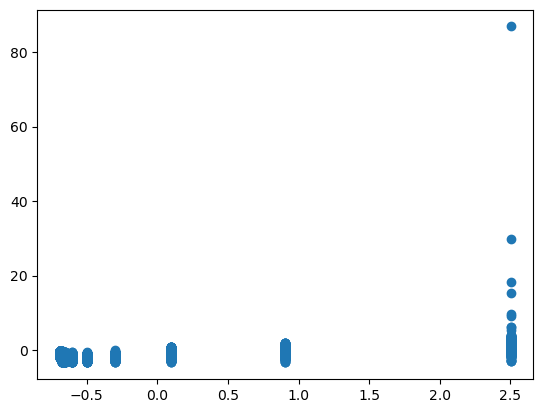

In [9]:
mypreds_true=mypreds*std_target + mean_target
Y_test_true= Y_test*std_target + mean_target
plt.scatter(Y_test, mypreds)
#plt.hist(mypreds_true)
#plt.hist(mypreds_true, bins=100, range=(0,300))

(0.0, 10.0)

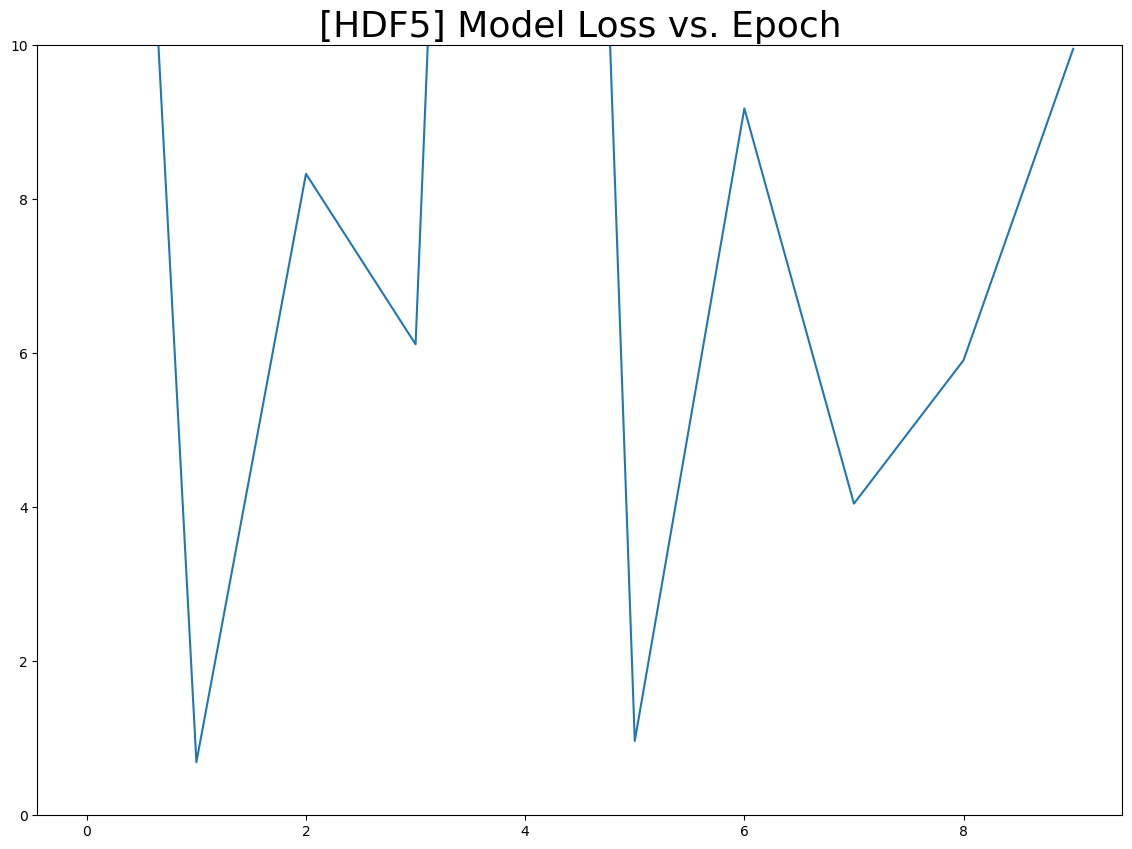

In [15]:
fig,axes=plt.subplots(figsize=(14,10))
axes.plot(model_fit.history['loss'])
#axes.plot(model_fit.history['val_loss'])
axes.set_title('[HDF5] Model Loss vs. Epoch',fontsize=26)
axes.set_ylim(0,10)

Text(0.5, 1.0, '[HDF5] Predicted vs. Generated Energy')

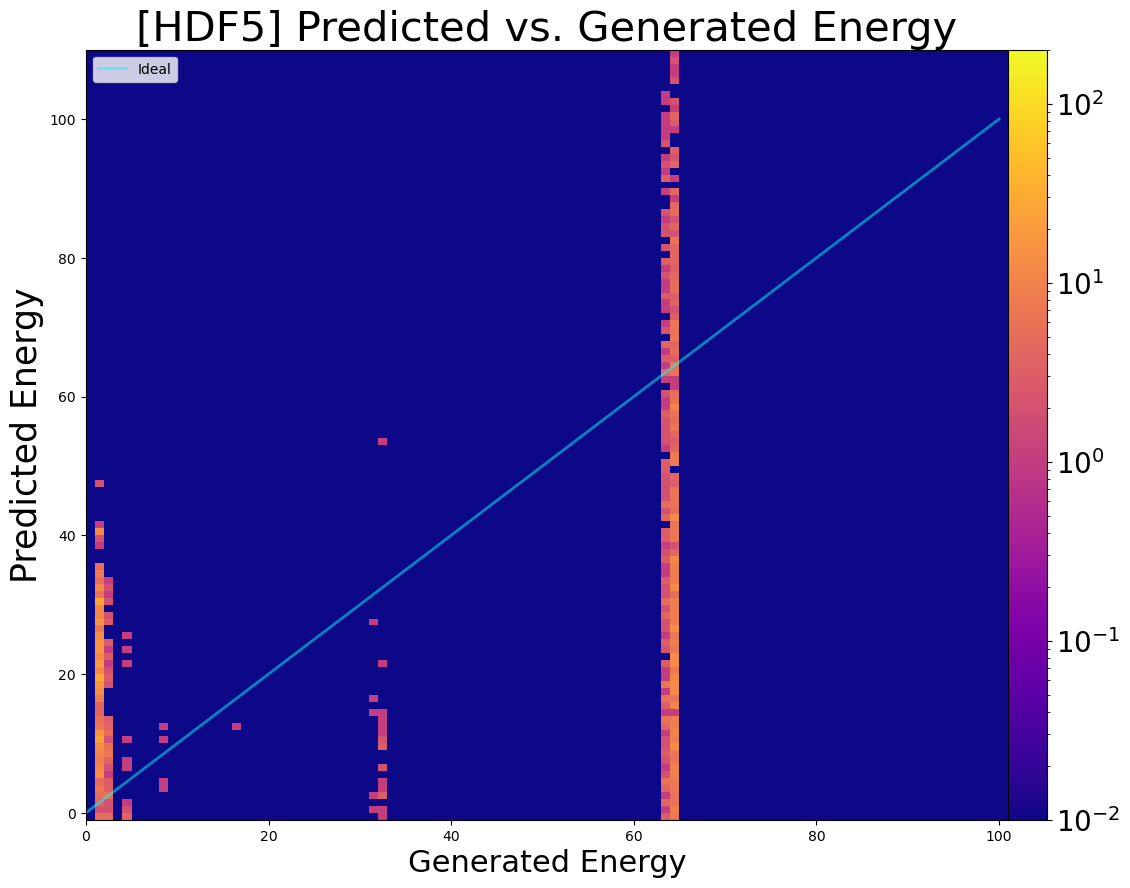

In [11]:
#fig, axes = plt.subplots(1, 2,figsize=(28,10),constrained_layout=True)
fig,axes=plt.subplots(figsize=(14,10))
#fig,axs = plt.subplots(int(N/10),10, figsize=(32, 16),sharex=False,sharey=True,constrained_layout=True)
#axes = axes.ravel()
from copy import copy
from matplotlib.colors import LogNorm
#fig, axes = plt.subplots(nrows=1, figsize=(14, 10), constrained_layout=True)
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))
edges=np.linspace(-10,110,121)
h, xedges, yedges = np.histogram2d(Y_test_true,mypreds_true[:,0], bins=[edges, edges])
#xedges=yedges
pcm = axes.pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmin=1.0e-2,vmax=2.0e2), rasterized=True)
cb = fig.colorbar(pcm, ax=axes, pad=0)
#cb.set_label("Counts",fontsize=22)
cb.ax.tick_params(labelsize=20)
axes.set_xlabel("Generated Energy",fontsize=22)
#axes[0].set_yticks(fontsize=20)
#axes[0].set_xticks(fontsize=20)
axes.set_ylim(-1,110)
axes.set_xlim(-0,101)
axes.plot([0, 100], [0, 100], color="cyan",linewidth=2,alpha=0.5,label="Ideal")
axes.legend(loc="upper left")
axes.set_ylabel("Predicted Energy",fontsize=25)
axes.set_title("[HDF5] Predicted vs. Generated Energy",fontsize=30)


In [12]:
from scipy.optimize import curve_fit
def gaussian(x, amp, mean, sigma):
    return amp * np.exp( -0.5*((x - mean)/sigma)**2) /sigma
# Get Resolution, scale, and distributions of Pred/X in bins of truth Using fit      
def get_res_scale_fit_log_local(truth, pred, file_name, num_bins, upto=256):
    nbins=num_bins
    import math
    ## Number of generated energy len(1, 2, 4, 8 ...)
    nn=int(np.log2(upto)) +1
    binning=[]
    
    ## Get the Generated Energy
    for n in range(0,nn):
        egen=pow(2,n)
        binning.append(egen)   
    print(nn, '   ', binning)    
    
    
    ## This should be same as binning[nn-1]
    max_ene_generated=int(np.amax(truth))
    
    ## This is same as nn
    N_Bins=int(np.log2(max_ene_generated))+1
    #print(max_ene_generated,'  ', N_Bins)
    
    #N_Bins=len(binning)  
    FIT_SIGMA=23## fit within +- 3 sigma    
    times=0.5    ## draw histogram within +- times sigma      
    bin_width=1 ## bin width of the histogram to be fitted   
    row=math.ceil(np.sqrt(N_Bins))
    col=row
    
    resolution_arr=[]
    mean_arr=[]
    resolution_cor_arr=[]
    scale_arr=[]
    avg_truth_arr=[]
    slices_arr=[]
    slices_truth_arr=[]
    scale_median_arr=[]
    fig,axs = plt.subplots(row,col, figsize=(22, 10),sharex=False)#,constrained_layout=True)
    if (len(truth) != len(pred)):
        print("truth and prediction arrays must be same length")
        return

    #binning = np.linspace(min,max,N_Bins+1)
    truth=np.rint(truth)
    indecies = np.digitize(truth,binning)-1 #Get the bin number each element belongs to.
    
    indecies[indecies<0]=0
    max_count = np.bincount(indecies).max()
    slices = np.empty((len(binning),max_count))
    slices_truth=np.empty((len(binning),max_count))
    slices_truth.fill(np.nan)
    slices.fill(np.nan)
    
    counter = np.zeros(len(binning),int) #for getting mean from sum, and incrementing element number in bin
    avg_truth = np.zeros(len(binning),float)
    pred_over_truth = np.zeros(len(binning),float)
    #xticks=np.linspace(0,E_xmax,6)
    one_ytics=round(max_count,-3)## round to thousand  
    yticks=np.linspace(0,one_ytics,6)
    
    for i in range(len(pred)):
        bin = indecies[i]
        if (bin>=len(binning)): continue
        slices[bin][counter[bin]] = pred[i] #slice_array[bin number][element number inside bin] = pred[i]   
        slices_truth[bin][counter[bin]] = truth[i]
        counter[bin]+=1

        avg_truth[bin]+=truth[i]
        pred_over_truth[bin] += pred[i]/truth[i]

    
    counter[counter == 0] = 1
    avg_truth = avg_truth/counter
    
    stdev_pred = np.nanstd(slices,axis=1)
    avg_pred   = np.nanmean(slices,axis=1)
    stdev_truth = np.nanstd(slices_truth,axis=1)
    median_pred=np.nanmedian(slices,axis=1)
    for ii in range(0,len(binning)):
        ## guess parameters for fitting    
        mean_guess=avg_pred[ii]
        sigma_guess=stdev_pred[ii]

        ## min and max range for histogram to be fitted to extract resolution/scale  
        min_range=binning[ii] - times*binning[ii]
        max_range=binning[ii] + times*binning[ii]
        
        
        
        #print(min_range, ' min and max range ', max_range,  'for binning' , binning[ii] )
        # print(mean_guess,'   ',sigma_guess)    
        #int((max_range-min_range)/bin_width)
        ## mean value of range within which histogram is draw    
        mean_here=(min_range + max_range)/2.0
        #print(mean_here)
        irow=int(ii/row)
        icol=int(ii%row)
        
        #print(irow,"  ", icol)    
        ax = axs[irow,icol]
        #print(nbins,'  ',min_range , '    ', max_range)
        
        count, bins,_=ax.hist(slices[ii].ravel(),bins=nbins,alpha=0.5,range=(min_range,max_range),label='HCALI',\
                              color='b',linewidth=8)
        
        #print( " energy   ", binning[ii], "      nbins    ", nbins)
         
        binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

        mask=(binscenters>(mean_guess-FIT_SIGMA*sigma_guess)) & (binscenters<(mean_guess+FIT_SIGMA*sigma_guess))
        error_counts=np.sqrt(count)
        error_counts=np.where(error_counts==0,1,error_counts)
        
        # PARAMETER BOUNDS ARE NOT USED FOR NOW       
        param_bounds=([-np.inf,-np.inf,-np.inf], [np.inf,np.inf,np.inf])
        
        '''
        popt, pcov = curve_fit(gaussian,binscenters[mask],count[mask],p0=[np.max(count),mean_guess,sigma_guess],bounds=param_bounds)

        ax.plot(binscenters[mask], gaussian(binscenters[mask], *popt), color='red', linewidth=2.5, label=r'F')
        '''
        #mean=popt[1]
        #std=popt[2]
        mean=0
        std=0
        
        #ax.set_xticks(xticks,fontsize=15)
        ax.set_xlim(math.floor(min_range),math.ceil(max_range))
        for_plot=round(binning[ii])
        y_text_val=int(np.max(count))*0.7
        ax.text(binning[ii],y_text_val,"$E_{True}$" + "= {0:.0f} GeV".format(for_plot),fontsize=15)
        if irow==row-1:
           ax.set_xlabel('Predicted Energy (GeV)',fontsize=15)

        if icol==0:
           ax.set_ylabel("Entries",fontsize=15)


        plt.savefig(file_name)
        
        
        
        #mean=np.nanmean(slices[ii])
        #std=np.nanstd(slices[ii])
        #print(mean, 'Mean and std ', std)
        
        resolution=std/avg_truth[ii]
        scale_median=median_pred[ii]/avg_truth[ii]
        scale=mean/avg_truth[ii]
        resolution_scale_corr=(std/avg_truth[ii])/scale
        resolution_scale_corrected=np.nan_to_num(resolution_scale_corr)

        resolution_arr.append(resolution)
        mean_arr.append(mean)
        resolution_cor_arr.append(resolution_scale_corrected)
        scale_arr.append(scale)
        slices_arr.append(slices[ii])
        avg_truth_arr.append(avg_truth[ii])
        scale_median_arr.append(scale_median)
        slices_truth_arr.append(slices_truth[ii])
        
    return resolution_arr,scale_arr,avg_truth_arr,slices_arr,resolution_cor_arr, scale_median_arr, slices_truth_arr

9     [1, 2, 4, 8, 16, 32, 64, 128, 256]


/tmp/ipykernel_1322410/85738510.py:153: RuntimeWarning: invalid value encountered in double_scalars
  resolution_scale_corr=(std/avg_truth[ii])/scale


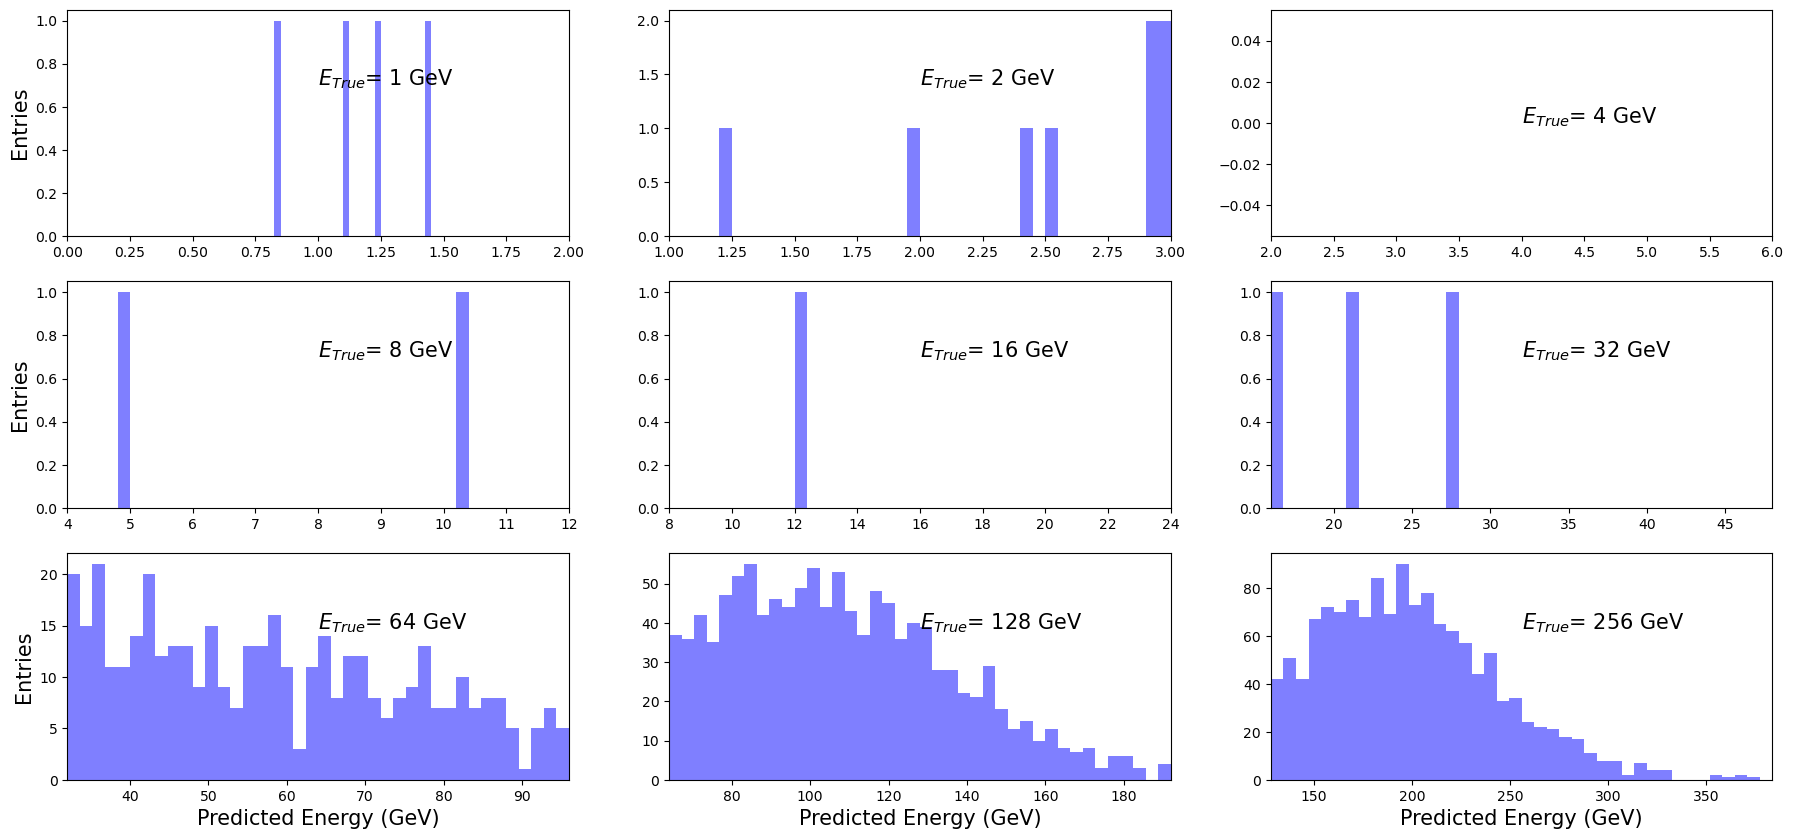

In [13]:
#from data_functions import *
save_slices=True
log_data=True
nbins=40
ene_upto=256

resolution_fit, pred_over_truth_fit, true_fit,slices_fit,resolution_scale_corr_fit, median_scale_fit,slices_truth = \
    get_res_scale_fit_log_local(Y_test_true, mypreds_true,\
                                "test.png",nbins,ene_upto)

In [14]:
label=""
fig=plt.figure(figsize=(14,10))
plt.title("AI Codesign Resolution ({0})".format(greek_particle),fontsize=25)
plt.ylabel("$(\sigma_{E,\mathrm{Pred}}/E_\mathrm{Truth})$",fontsize=24)
plt.xlabel("$E_\mathrm{Truth}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
#plt.ylim(-0.02,0.4)
plt.ylim(0,2)
plt.ylim(0.,.32)
#plt.xlim(-0.01,100.01)
#plt.xlim(5.0,110)
#check_val_error=2*counter-2
#check_val_error[check_val_error == 0] = 1 

    
#errors = 1.0/(np.sqrt(check_val_error))*stdev_pred      

ax = plt.subplot(1,1,1)
#first_bin = 0
#last_bin = N
#print('',N)


#print(errors[first_bin:last_bin])
plt.text(0.8,-0.08,label,transform=ax.transAxes,fontsize=10)
#errors_arth = np.zeros(len(true_arth))
errors_fit = np.zeros(len(true_fit))

plt.errorbar(true_fit,resolution_scale_corr_fit,
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',marker="o",
             color='blue',alpha=0.7,label=" PFN (Using parameters from fit)")

#print(Gen_energy)
#["{0:0.2f}".format(i) for i in a]
print(["{0:0.2f}".format(i) for i in resolution_fit])

NameError: name 'greek_particle' is not defined

<Figure size 1400x1000 with 0 Axes>

In [ ]:
fig=plt.figure(figsize=(14,10))
plt.title("Prediction vs Truth ({0})".format(greek_particle),fontsize=25)
plt.ylabel("$(E_\mathrm{Pred}/E_\mathrm{Truth})$",fontsize=24)
plt.xlabel("$E_\mathrm{Truth}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.axhline(y=1.0, color='r', linestyle='--',alpha=0.5)#plt.ylim(-0.02,0.4)
plt.ylim(0.5,1.2)
#plt.xlim(-1,101)
#counter[counter<2]=1.5
#errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred
#errors_scale = np.zeros(len(energies_pi))
ax = plt.subplot(1,1,1)
#first_bin = 0
#last_bin = N
errors_fit=np.zeros(len(true_fit))


plt.errorbar(true_fit,pred_over_truth_fit,
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',marker="o",
            alpha=0.7,label="PFN (Using Mean of Fit)")
#_ = plt.text(0.7,0.93,"Stat. Error: $\dfrac{\sigma}{\sqrt{2N-2} } $",transform=ax.transAxes,fontsize=20)

print( pred_over_truth_fit)